In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [203]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\relaxation\sio2'
file_name =  "3500-out_relax.lmp"
file_path = os.path.join(root,file_name)

start_frame = 0
end_frame = 400
step_frame = 1
###########

# 要分析的元素
ana_element = ['Si','O']
# lmp对应的值
dic_charge = {2.4:'Si', -1.2:'O', 1.8:'Al', 0.6:'Li'}
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [205]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Atom:
    def __init__(self, id0=None, type0=None, q=None, x=None, y=None, z=None, 
                 vx=None, vy=None, vz=None, fx=None, fy=None, fz=None, 
                 c_ke_atom=None, c_pe_atom=None, v_e_total=None, frame=None, q4=None,q6=None,dis=None):
        self.id = int(id0)
        self.type = str(type0)
        self.x = x
        self.y = y
        self.z = z
        self.q = q
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = fx
        self.fy = fy
        self.fz = fz
        self.c_ke_atom = c_ke_atom
        self.c_pe_atom = c_pe_atom
        self.v_e_total = v_e_total
        self.q4 = q4
        self.q6 = q6
        self.dis = dis
        self.frame = frame
    def print_info(self):
        print(f'id:{int(self.id)}, type:{self.type}, x:{self.x}, y:{self.y}, z:{self.z}, q:{self.q}')
        print(f'vx:{self.vx}, vy:{self.vy}, vz:{self.vz}, fx:{self.fx}, fy:{self.fy}, fz:{self.fz}')
        print(f'E_total:{self.v_e_total}, E_kinetic:{self.c_ke_atom}, E_potential:{self.c_pe_atom}')
        print(f'q4:{self.q4} dis:{self.q6} q6:{self.dis} frame:{self.frame}')

In [207]:
def read_lmp(file_path):
    # 所有信息储存的总列表
    list_all_frames = []
    x_min,x_max,y_min,y_max,z_min,z_max = None,None,None, None,None,None
    box_size = [None, None, None]
    num_atom = None
    len_per_frame = None
    # 第一次打开,是看一下基本数据：
    with open(file_path,'r') as f_open:
        # 前三行都不要
        for i in range(3): 
            f_open.readline()
        # 第四行是Number
        num_atom = int(f_open.readline())
        # 定义一页的行数
        len_per_frame = num_atom + 9  
        # 第五行不要
        f_open.readline()
        # 存储range范围
        temp_range_list = []
        for i in range(3): 
            # 无论是两个还是三个都可以 
            temp = f_open.readline().split()
            temp_min,temp_max = temp[0],temp[1]
            temp_range_list.append(temp_min)
            temp_range_list.append(temp_max)
        # 将字符串转换为浮点数并直接赋值给变量
        x_min, x_max, y_min, y_max, z_min, z_max = [float(i) for i in temp_range_list]
    print(f'Num of atom: {num_atom}')
    print(f'X range: {x_min}  {x_max}')
    print(f'Y range: {y_min}  {y_max}')
    print(f'Z range: {z_min}  {z_max}\n')
    
    # 开始读取文件
    f_open = open(file_path,'r')
    # 记录当前行数
    count_row = 0
    for i_frame in range(start_frame, end_frame, step_frame):
        if i_frame%50==0:
            print(f'Now is reading frame {i_frame}')
        list_frame = []
        # 先判断下是不是我要的这页
        now_frame_count = len_per_frame*i_frame
        # 如果不是同一页，则跳过这一页,再继续空读
        while count_row!=now_frame_count:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            count_row+=len_per_frame
            for i in range(len_per_frame):
                f_open.readline()
        # 如果是同一页，那么就开始读取数据
        else:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            # 首先就是跳过表头的9行
            # for i in range(9):
            #     f_open.readline()
            # 读取表头九行的数据
            is_end = f_open.readline()
            if is_end=='':
                print(f'读取到文件尾，frame:{i_frame}.')
                break
            time_step = int(f_open.readline())
            f_open.readline()
            atom_num = float(f_open.readline())
            f_open.readline()
            # 有的是2 有的是三个
            temp = f_open.readline()
            x_low,x_high = temp.split()[0],temp.split()[1]
            temp = f_open.readline()
            y_low,y_high = temp.split()[0],temp.split()[1]
            temp = f_open.readline()
            z_low,z_high = temp.split()[0],temp.split()[1]
            f_open.readline()
            x_low,x_high,y_low,y_high,z_low,z_high = float(x_low),float(x_high),float(y_low),float(y_high),float(z_low),float(z_high)
            dic_system = {'timestep':time_step, 
                         'num_atoms':atom_num,
                          'x_low':x_low,'x_high':x_high,
                          'y_low':y_low,'y_high':y_high,
                          'z_low':z_low,'z_high':z_high,
                         }
            # 再读取其余的数据
            for j_row in range(num_atom):
                temp_data = f_open.readline().split()
                temp_float = [float(i) for i in temp_data]
                # 
                id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz = [float(i) for i in temp_data]
                #print(id0, type0, q, x, y, z)
                # 类型转换回 str
                type0 = dic_charge[q]
                temp_atom = Atom(id0=id0, type0=type0, q=q, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz, fx=fx, fy=fy, fz=fz, frame=i_frame)
                list_frame.append(temp_atom)
            # 这一页读取完了,首先是对原子的id排序
            list_frame = sorted(list_frame, key = lambda Atom:Atom.id)
            # 再存入信息帧中
            frame_data = {
                "atom_data":list_frame,
                'system_info':dic_system
            }
            list_all_frames.append(frame_data)
            count_row+=len_per_frame
         
    # 关闭文件
    print('文件读取完毕！')
    f_open.close()
    return list_all_frames
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)
    print('文件读取完毕！')
    return frames

In [209]:
file_type = file_path.split('\\')[-1].split('.')[-1]
frames = []
if file_type=='lmp':
    print('输入文件为lmp格式！')
    frames = read_lmp(file_path)   
elif file_type=='xyz':
    frames = read_xyz_frames(file_path)
    # 找出最大的x、y和z值
    max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
    max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
    max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])
    print("Maximum X value:", max_x)
    print("Maximum Y value:", max_y)
    print("Maximum Z value:", max_z)
else:
    print('输入文件有误！')

输入文件为lmp格式！
Num of atom: 9999
X range: -0.018407842146956455  53.110982842146385
Y range: -0.018407842146956455  53.110982842146385
Z range: -0.018407842146956455  53.110982842146385

Now is reading frame 0
Now is reading frame 50
Now is reading frame 100
Now is reading frame 150
Now is reading frame 200
Now is reading frame 250
Now is reading frame 300
Now is reading frame 350
文件读取完毕！


In [210]:
frames[0]['atom_data'][0].print_info()
frames[20]['atom_data'][-1].print_info()
frames[0]['system_info']

id:1, type:O, x:14.9321, y:7.41396, z:9.59928, q:-1.2
vx:-9.72183, vy:-3.46379, vz:-19.081, fx:-0.132956, fy:0.14253, fz:4.81247
E_total:None, E_kinetic:None, E_potential:None
q4:None dis:None q6:None frame:0
id:9999, type:Si, x:34.0418, y:2.58492, z:17.9527, q:2.4
vx:-3.84046, vy:-2.09967, vz:7.90279, fx:-3.99184, fy:2.00321, fz:0.180337
E_total:None, E_kinetic:None, E_potential:None
q4:None dis:None q6:None frame:20


{'timestep': 500000,
 'num_atoms': 9999.0,
 'x_low': -0.018407842146956455,
 'x_high': 53.110982842146385,
 'y_low': -0.018407842146956455,
 'y_high': 53.110982842146385,
 'z_low': -0.018407842146956455,
 'z_high': 53.110982842146385}

# 相关函数

In [212]:
dic_element = {'Si':28.086,'O':16.0,'Li':6.941}

In [213]:
def cal_ppp_dis_object(boxsize,point1,point2):
    i_1 = np.array([point1.x,point1.y,point1.z])
    j_1 = np.array([point2.x,point2.y,point2.z])
    boxsize = np.array(boxsize)
    # 计算
    delta = i_1-j_1
    delta = delta - np.round(delta / boxsize) * boxsize
    distance = np.linalg.norm(delta)
    return distance

In [214]:
def cal_Pxy(atom_list):
    # 遍历原子，然后
    kinetic_part = 0.0     # 动能部分
    potential_part = 0.0   # 势能部分
    for i_atom in atom_list:
        m = dic_element[i_atom.type]
        kinetic_part += m*i_atom.vx*i_atom.vy
        potential_part += i_atom.x*i_atom.fy
    P_xy = kinetic_part+potential_part
    return P_xy

In [215]:
cal_Pxy(frames[0]['atom_data'])

297454.6785269814

# 参数设置

In [237]:
start_frame = 0
end_frame = 200
step_frame = 1
ana_list = frames[start_frame:end_frame:step_frame]

# 读取文件完毕

In [240]:
test_list = ana_list
###########
dic_element = {'Si':28.086,'O':16.0,'Li':6.941}
volume = (0.5*(test_list[0]['system_info']['x_high']+test_list[-1]['system_info']['x_high']))**3

In [242]:
import numpy as np

test_list = ana_list
# 假设你已经有了很多帧 atom_list_all，每一帧是所有原子的信息
Pxy_list = [None]*len(test_list)
for i,atom_list in enumerate(test_list):
    Pxy = cal_Pxy(atom_list['atom_data'])
    Pxy_list[i] = Pxy
Pxy_array = np.array(Pxy_list)

# 计算自相关函数
def autocorrelation(Pxy_array):
    n = len(Pxy_array)
    acf = np.zeros(n)
    for t in range(n):
        valid = Pxy_array[:n-t]
        shifted = Pxy_array[t:]
        acf[t] = np.mean(valid * shifted)
    return acf
C_t = autocorrelation(Pxy_array)

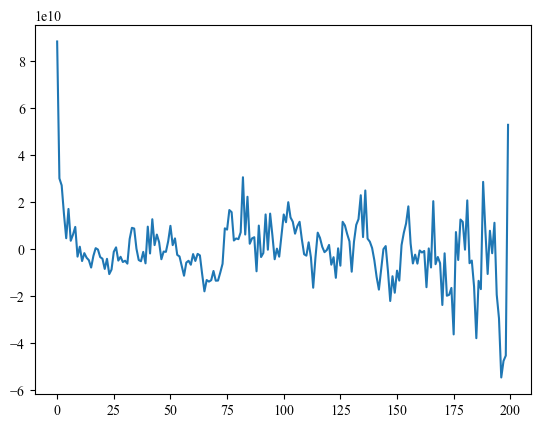

In [243]:
plt.plot(range(len(C_t)),C_t)

# 单位转换 基于Green-Kubo的粘度计算

In [247]:
import numpy as np

# constants
kB = 1.380649e-23  # Boltzmann constant in J/K
eV_to_J = 1.60218e-19  # 1 eV = 1.60218e-19 J
A_to_m = 1e-10  # 1 Å = 1e-10 m
eV_A3_to_Pa = 1.60218e11  # 1 eV/Å³ = 1.60218e11 Pa

# system parameters
T = 1500  # K, your temperature
# s, your time step = 0.1 ns = 1e-10 s
# 前面单位是 ps 就是看有多少个 三个0就是ps
dt = 10e-15 

# Assume you have already calculated a list of Pxy values in eV/Å³
Pxy_list = Pxy_list

# volume in Å³ -> m³
V_A3 = volume
V_m3 = V_A3 * (A_to_m**3)  # now in m³

# convert Pxy to Pa
Pxy_array = np.array(Pxy_list) * eV_A3_to_Pa

# compute autocorrelation
def autocorrelation(x):
    n = len(x)
    result = np.correlate(x, x, mode='full')
    result = result[n-1:]  # only positive times
    result /= np.arange(n, 0, -1)  # normalize (number of terms)
    return result

C_t = autocorrelation(Pxy_array)

# integration
integral = np.trapz(C_t, dx=dt)

# calculate viscosity
eta = (V_m3 / (kB * T)) * integral  # result in Pa.s

print(f"Viscosity η = {eta:.3e} Pa·s")


Viscosity η = -2.818e+14 Pa·s


# 基于Einstein–Gelfand的粘度计算

In [98]:
start_frame = 0
end_frame = 100
step_frame = 1
ana_list = frames[start_frame:end_frame:step_frame]

In [100]:
def cal_dt(frame_0,frame_t):
    res_0,res_t = 0,0
    for atom_0,atom_t in zip(frame_0,frame_t):
        res_0 += (atom_0.x*atom_0.vy*dic_element[atom_0.type])
        res_t += (atom_t.x*atom_t.vy*dic_element[atom_t.type]) 
    res = (res_t-res_0)**2
    return res

In [102]:
dt_res = [None]*len(ana_list)
for i_num,i_frame in enumerate(ana_list):
    frame_0 = ana_list[0]['atom_data']
    frame_t = i_frame['atom_data']
    dt = cal_dt(frame_0,frame_t)
    dt_res[i_num] = dt
# 
res = autocorrelation(dt_res)

In [104]:
def autocorrelation(data):
    # 计算自相关函数：C(t) = <X(t) * X(0)> / <X(0)^2>
    n = len(data)
    mean = np.mean(data)
    autocorr = np.zeros(n)
    for t in range(n):
        autocorr[t] = np.mean((data[:n-t] - mean) * (data[t:] - mean)) / np.var(data)
    return autocorr

In [106]:
res = autocorrelation_direct(dt_res)

NameError: name 'autocorrelation_direct' is not defined

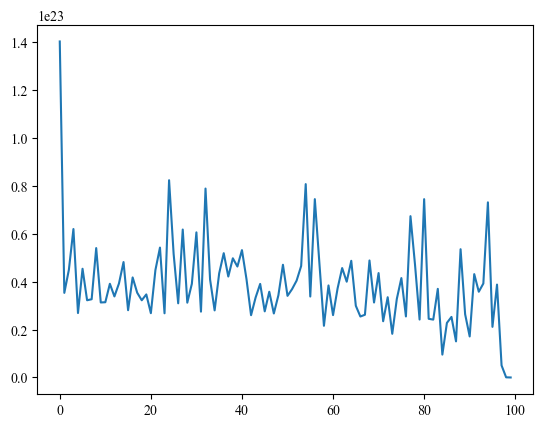

In [108]:
plt.plot(range(len(res)),res)

In [110]:
import numpy as np

def autocorrelation_direct(series, max_lag=None):
    """
    计算时间序列的自相关系数（ACF）
    
    参数:
        series: 输入的时间序列（列表或NumPy数组）
        max_lag: 最大延迟步长（默认为序列长度的一半）
    
    返回:
        acf: 自相关系数数组，长度=max_lag
    """
    n = len(series)
    if max_lag is None:
        max_lag = n // 2  # 默认取一半长度
    mean = np.mean(series)
    var = np.var(series)
    acf = np.zeros(max_lag)
    
    for t in range(max_lag):
        cov = np.sum((series[:n-t] - mean) * (series[t:] - mean)) / n
        acf[t] = cov / var  # 归一化
    
    return acf

In [112]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
acf = autocorrelation_direct(data)
print("自相关系数:", acf)

自相关系数: [ 1.          0.7         0.41212121  0.14848485 -0.07878788]


In [114]:
# compute autocorrelation
def autocorrelation(x):
    n = len(x)
    result = np.correlate(x, x, mode='full')
    result = result[n-1:]  # only positive times
    result /= np.arange(n, 0, -1)  # normalize (number of terms)
    return result

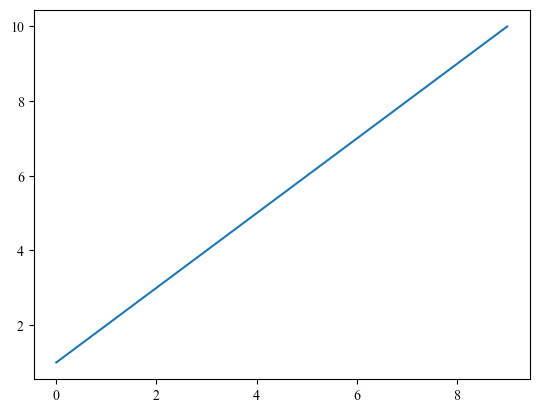

In [116]:
plt.plot(range(len(data)),data)

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# 常数定义
k_B = 1.380649e-23  # 玻尔兹曼常数，单位：J/K
T = 1500  # 温度，单位：K
V = volume  # 体积，单位：Å³ (假设体积为1 Å³，实际值根据系统来设定，1 Å³ = 1e-30 m³)
time_diff = 0.1e-9  # 时间差，单位：秒 (0.1ns = 0.1e-9秒)

# 示例：填充数据（实际数据应来自你的模拟）
# 假设 ana_list 是你的数据集，其中包含多个帧，每个帧包含 atom_data
# 这里模拟一些数据
def cal_dt(frame_0, frame_t):
    # 计算应力张量的差异并进行平方
    res_0, res_t = 0, 0
    for atom_0, atom_t in zip(frame_0, frame_t):
        res_0 += atom_0.x * atom_0.vy * dic_element[atom_0.type]
        res_t += atom_t.x * atom_t.vy * dic_element[atom_t.type]
    
    # 平方差异
    return (res_t - res_0) ** 2

def autocorrelation(data):
    # 计算自相关函数：C(t) = <X(t) * X(0)> / <X(0)^2>
    n = len(data)
    mean = np.mean(data)
    autocorr = np.zeros(n)
    for t in range(n):
        autocorr[t] = np.mean((data[:n-t] - mean) * (data[t:] - mean)) / np.var(data)
    return autocorr

# 计算粘度的函数
def calculate_viscosity(ana_list):
    dt_res = [None] * len(ana_list)
    
    # 计算每对帧的差异
    for i_num, i_frame in enumerate(ana_list):
        frame_0 = ana_list[0]['atom_data']
        frame_t = i_frame['atom_data']
        dt = cal_dt(frame_0, frame_t)
        dt_res[i_num] = dt
    
    # 计算自相关函数
    res = autocorrelation(dt_res)

    # 数值积分计算粘度
    # viscosity = np.trapz(res)  # 使用数值积分来估算粘度
    
    # 单位转换
    # 1 Å³ = 1e-30 m³
    # 1 ns = 1e-9 s, 0.1 ns = 0.1e-9 s
    viscosity = viscosity * V * k_B * T * time_diff * 1e30  # 转换为合适的单位，最终单位为Pa·s

    return viscosity

# 调用函数计算粘度
viscosity = calculate_viscosity(ana_list)
print(f"viscosity: {viscosity} Pa·s")


UnboundLocalError: cannot access local variable 'viscosity' where it is not associated with a value

In [120]:
def autocorrelation(x):
    x = np.array(x)
    n = len(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]  # 取正的部分
    result = result / (n - np.arange(n))  # 归一化
    return result

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# 常数定义
k_B = 1.380649e-23  # 玻尔兹曼常数，单位：J/K
T = 1500  # 温度，单位：K
time_diff = 0.1e-9  # 相邻两帧时间差，单位：秒

# 元素质量字典（单位u）
dic_element_mass = {
    "Si": 28.085,
    "O": 15.999,
    "Li": 6.94,
}

# 计算 Helfand moment 差异平方
def cal_dt(frame_0, frame_t):
    res = 0
    for atom_0, atom_t in zip(frame_0, frame_t):
        mass_u = dic_element_mass[atom_0.type]
        mass_kg = mass_u * 1.66053906660e-27  # 质量u转kg
        x0 = atom_0.x * 1e-10  # Å -> m
        xt = atom_t.x * 1e-10
        vy0 = atom_0.vy * 1e2  # Å/ps -> m/s
        vyt = atom_t.vy * 1e2
        p0_y = mass_kg * vy0
        pt_y = mass_kg * vyt
        
        res += (xt * pt_y - x0 * p0_y)

    return res**2  # 最后整体平方

# 主函数：计算粘度
def calculate_viscosity(ana_list, volume):
    V_m3 = volume * 1e-30  # Å³ -> m³

    dt_list = []
    for frame_t in ana_list:
        frame_0 = ana_list[0]['atom_data']
        frame_tt = frame_t['atom_data']
        dt_val = cal_dt(frame_0, frame_tt)
        dt_list.append(dt_val)

    dt_list = np.array(dt_list)
    acf = autocorrelation(dt_list)
    # 横坐标时间
    times = np.arange(len(dt_list)) * time_diff  # 秒

    # 计算η(t)
    eta_t = acf / (2 * k_B * T * V_m3*times)


    return eta_t

# 调用
# viscosity = calculate_viscosity(ana_list, volume)
# print("粘度 =", viscosity, "Pa·s")


In [124]:
import numpy as np
import matplotlib.pyplot as plt

# 常数定义
k_B = 1.380649e-23  # 玻尔兹曼常数，J/K
T = 1500  # 温度，K
time_diff = 0.1e-9  # 相邻两帧时间差，秒

# 元素质量字典（单位u）
dic_element_mass = {
    "Si": 28.085,
    "O": 15.999,
    "Li": 6.94,
}

# 计算 Helfand moment 差异平方
def cal_dt(frame_0, frame_t):
    res = 0
    for atom_0, atom_t in zip(frame_0, frame_t):
        mass_u = dic_element_mass[atom_0.type]
        mass_kg = mass_u * 1.66053906660e-27  # u -> kg
        x0 = atom_0.x * 1e-10  # Å -> m
        xt = atom_t.x * 1e-10
        vy0 = atom_0.vy * 1e2  # Å/ps -> m/s
        vyt = atom_t.vy * 1e2
        p0_y = mass_kg * vy0
        pt_y = mass_kg * vyt
        
        res += (xt * pt_y - x0 * p0_y)

    return res**2  # 最后整体平方

# 主函数：计算粘度
def calculate_viscosity(ana_list, volume):
    V_m3 = volume * 1e-30  # Å³ -> m³

    dt_list = []
    for frame_t in ana_list:
        frame_0 = ana_list[0]['atom_data']
        frame_tt = frame_t['atom_data']
        dt_val = cal_dt(frame_0, frame_tt)
        dt_list.append(dt_val)

    dt_list = np.array(dt_list)

    # 横坐标时间
    times = np.arange(len(dt_list)) * time_diff  # 秒

    # 计算η(t) 注意要除以t
    eta_t = dt_list / (2 * k_B * T * V_m3 * times)

    # 第一个点t=0会除以0，需要处理掉
    eta_t[0] = np.nan  # 或者直接忽略
    return times, eta_t

# 调用示例
# times, viscosity = calculate_viscosity(ana_list, volume)
# plt.plot(times[1:], viscosity[1:])
# plt.xlabel('Time (s)')
# plt.ylabel('Viscosity (Pa·s)')
# plt.show()


C:\Users\81004\AppData\Local\Temp\ipykernel_20068\2780526444.py:50: RuntimeWarning: invalid value encountered in divide
  eta_t = dt_list / (2 * k_B * T * V_m3 * times)


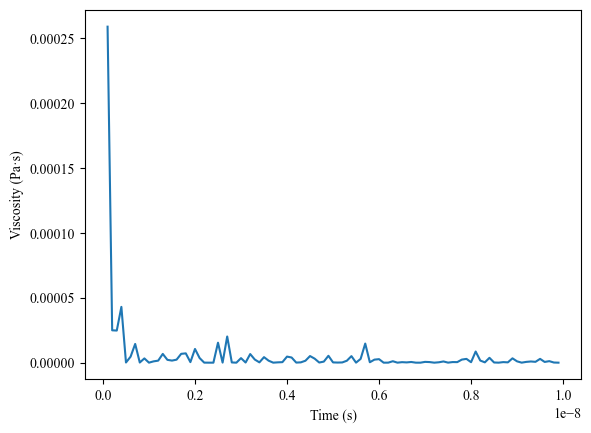

In [126]:
# 调用示例
times, viscosity = calculate_viscosity(ana_list, volume)
plt.plot(times[1:], viscosity[1:])
plt.xlabel('Time (s)')
plt.ylabel('Viscosity (Pa·s)')
plt.show()

In [128]:
eta_t = calculate_viscosity(ana_list, volume)

C:\Users\81004\AppData\Local\Temp\ipykernel_20068\2780526444.py:50: RuntimeWarning: invalid value encountered in divide
  eta_t = dt_list / (2 * k_B * T * V_m3 * times)


In [130]:
len(eta_t)

2

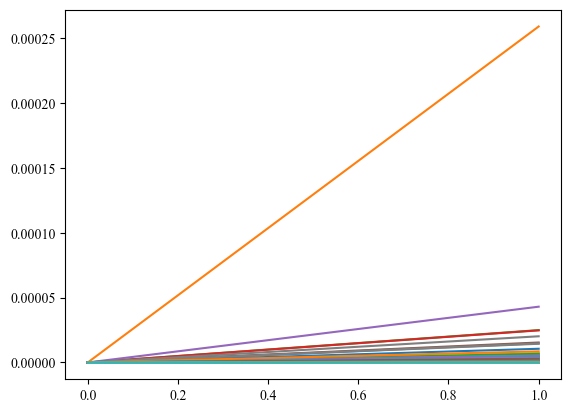

In [132]:
plt.plot(range(len(eta_t)),eta_t)
#plt.ylim(0,1)